# Clone data from GitHub

In [2]:
# Clone the ZZSC9020 project repository from GitHub
#!git clone https://github.com/UNSW-ZZSC9020-2023H2/project.git

In [8]:
# Create a data folder
# !mkdir -p data

In [10]:
# Joint forecastdemand_nsw files into a single file. 
# !cat Dakshi/data/forecastdemand_nsw.csv.zip.part* > data/forecastdemand_nsw.csv.zip

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
# Unzip the data files into the data folder
!unzip data/forecastdemand_nsw.csv.zip -d data
# !unzip project/data/temperature_nsw.csv.zip -d data
# !unzip project/data/totaldemand_nsw.csv.zip -d data

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
# Remove forecastdemand_nsw.csv.zip
# !rm data/forecastdemand_nsw.csv.zip

'rm' is not recognized as an internal or external command,
operable program or batch file.


# Import libraries

In [1]:
# Others
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# for data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error as mae

# for time series model
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for machine learning model



# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns


# Data preprocessing

In [2]:
# Load the data
totaldemand = pd.read_csv('data/totaldemand_nsw.csv',index_col='DATETIME').sort_index()
temperature = pd.read_csv('data/temperature_nsw.csv',index_col='DATETIME').sort_index()
# forecastdemand = pd.read_csv('data/forecastdemand_nsw.csv',index_col='DATETIME').sort_index()

In [3]:
# Check for NaN values
print(f'NaN values in totaldemand= {totaldemand.isna().sum().sum()}')
print(f'NaN values in temperature= {temperature.isna().sum().sum()}')
# print(f'NaN values in forecastdemand= {forecastdemand.isna().sum().sum()}')

NaN values in totaldemand= 0
NaN values in temperature= 0


In [4]:
# Check for zero or negative values
print(f'Zero or negative values in totaldemand= {((totaldemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
print(f'Zero or negative values in temperature= {((temperature.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
# print(f'Zero or negative values in forecastdemand= {((forecastdemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')

Zero or negative values in totaldemand= 0
Zero or negative values in temperature= 36


In [5]:
# Explore extreme temperature values
temperature.loc[temperature['TEMPERATURE']<=0]

,LOCATION,TEMPERATURE
DATETIME,,
2010-03-23 15:00:00,94766.0,-9999.0
2010-04-27 10:00:00,94766.0,-9999.0
2010-05-01 06:00:00,94766.0,-9999.0
2010-06-29 04:30:00,94766.0,-0.2
2010-06-29 05:30:00,94766.0,-0.1
2010-06-29 06:30:00,94766.0,-0.3
2010-06-30 04:30:00,94766.0,-0.3
2010-06-30 05:00:00,94766.0,-0.5
2010-06-30 05:30:00,94766.0,-0.4


In [6]:
# Remove rows with unreasonable values
temperature = temperature.loc[temperature['TEMPERATURE']!=-9999]

In [7]:
# Convert relevant columns to datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
totaldemand.index = pd.to_datetime(totaldemand.index, format=datetime_format)
temperature.index = pd.to_datetime(temperature.index, format=datetime_format)
# forecastdemand.index = pd.to_datetime(forecastdemand.index, format=datetime_format)
# forecastdemand['LASTCHANGED'] = pd.to_datetime(forecastdemand['LASTCHANGED'], format=datetime_format)

In [8]:
# Drop unwanted columns
totaldemand.drop(['REGIONID'],axis=1,inplace=True)
temperature.drop(['LOCATION'],axis=1,inplace=True)
# forecastdemand.drop(['REGIONID','PREDISPATCHSEQNO','PERIODID'],axis=1,inplace=True)

In [9]:
# Create the dataframe for modelling
df = totaldemand.resample('5T').median().interpolate() # resample demand to 5-min bins and fill NaN by linear interpolation
df = df.join(temperature).sort_index().interpolate() # join temperature data and fill NaN by linear interpolation
print(f'Check NaN in df: {df.isna().sum().sum()}')
print(df)

Check NaN in df: 0
                     TOTALDEMAND  TEMPERATURE
DATETIME                                     
2010-01-01 00:00:00      7997.41    23.100000
2010-01-01 00:05:00      7946.51    23.066667
2010-01-01 00:10:00      7921.55    23.033333
2010-01-01 00:15:00      7837.84    23.000000
2010-01-01 00:20:00      7781.11    22.966667
...                          ...          ...
2022-07-31 23:40:00      8180.34    12.500000
2022-07-31 23:45:00      8237.50    12.400000
2022-07-31 23:50:00      8109.83    12.300000
2022-07-31 23:55:00      8044.52    12.200000
2022-08-01 00:00:00      8027.28    12.100000

[1323361 rows x 2 columns]


In [18]:
# Create a dataframe for comaprison between actual and forecast demands
df_forecast = pd.merge(forecastdemand,totaldemand,left_index=True,right_index=True)
df_forecast['DURATION'] = (df_forecast.index - df_forecast['LASTCHANGED']).astype('timedelta64[h]').astype('int')
df_forecast['ERROR'] = abs(df_forecast['FORECASTDEMAND'] - df_forecast['TOTALDEMAND'])/df_forecast['TOTALDEMAND']*100
df_forecast.drop(['FORECASTDEMAND','TOTALDEMAND','LASTCHANGED'],axis=1,inplace=True)

In [11]:
# Set parameters for different prediction time frames

# Short term prediction: 1 day into the future
window_short = 'D'

# Medium term prediction: 1 week into the future
window_medium = 'W'

# Long term prediction: 1 month into the future
window_long = 'M'

In [12]:
# Resample df based on the windows to fit time series model
# Note: demand is divided by 1000 to convert to GW (gigawatts)

# Short term prediction:
ts_short = df.resample(window_short).agg({'TOTALDEMAND':lambda x:x.sum()/1000,'TEMPERATURE':'median'})
ts_short = ts_short.iloc[:-1] # remove the last value after resampling to 1D

# Medium term prediction:
ts_medium = df.resample(window_medium).agg({'TOTALDEMAND':lambda x:x.sum()/1000,'TEMPERATURE':'median'})
ts_medium = ts_medium.iloc[1:-1] # remove the first and last value after resampling to 1W

# Long term prediction:
ts_long = df.resample(window_long).agg({'TOTALDEMAND':lambda x:x.sum()/1000,'TEMPERATURE':'median'})
ts_long = ts_long.iloc[:-1] # remove last value after resampling to 1M

# Exploratory Data Analysis (EDA)

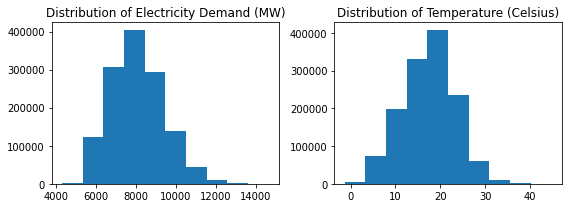

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot distributions of totaldemand and temperature
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
ax1.hist(df['TOTALDEMAND'])
ax1.title.set_text('Distribution of Electricity Demand (MW)')
ax2.hist(df['TEMPERATURE'])
ax2.title.set_text('Distribution of Temperature (Celsius)')
plt.tight_layout()
plt.show()
plt.clf()

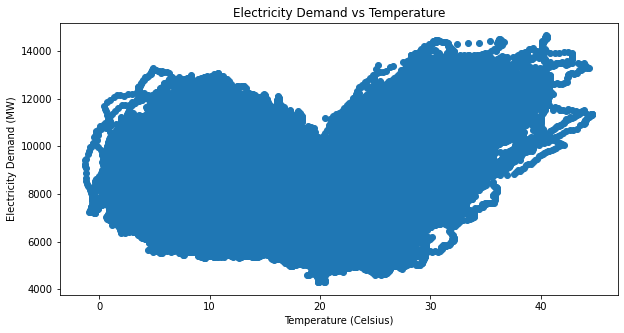

<function matplotlib.pyplot.clf()>

In [14]:
# Plot totaldemand vs temperature
plt.figure(figsize=[10, 5])
plt.scatter(df['TEMPERATURE'], df['TOTALDEMAND'])
plt.ylabel('Electricity Demand (MW)')
plt.xlabel('Temperature (Celsius)')
plt.title('Electricity Demand vs Temperature')
plt.show()
plt.clf

In [15]:
# Plot forecast error vs prediction time
plt.figure(figsize=[10, 5])
sns.boxplot(x='DURATION', y='ERROR', data=df_forecast).set(
    title='Forecast Error vs. Prediction Time',
    xlabel = 'Prediction Time (hours)',
    ylabel = 'Forecast Error (%)'
    )
plt.show()
plt.clf()

NameError: name 'df_forecast' is not defined

<Figure size 720x360 with 0 Axes>

## Key findings from EDA
*   Right-skewed distribution for electricity demand data
*   Normal distribution for temperature data
*   Non-linear (U shape) relationship between electricity demand and temperature
*   Electricity demand is the lowest around 20 degree Celsius
*   Electricity demand increases at a higher rate under (i.e. more sensitive to) extreme hot weather
*   The longest prediction time for forecast demand is around 39 hours ahead of actual demand
*   Prediction tends to be more accurate within 2 hours before actual demand
*   Boxplot shows many outliers of forecast errors which extend to over 30%, indicating poor prediction performance of current model
*   Overall, predictions made by the current model is very short term and not reliable, hence not useful for energy planning

# Time Series Model

## Identify seasonality and trend

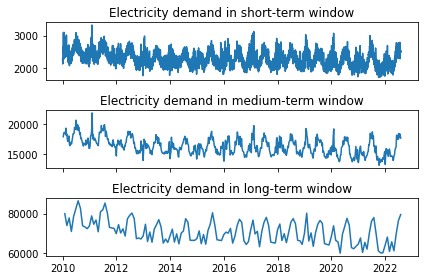

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot totaldemand vs time for different prediction time frames
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
ax1.plot(ts_short['TOTALDEMAND'])
ax1.title.set_text('Electricity demand in short-term window')
ax2.plot(ts_medium['TOTALDEMAND'])
ax2.title.set_text('Electricity demand in medium-term window')
ax3.plot(ts_long['TOTALDEMAND'])
ax3.title.set_text('Electricity demand in long-term window')
plt.tight_layout()
plt.show()
plt.clf()

### Findings on seasonality and trend:
*  Electricity demand shows seasonality patterns in all windows
*  Electricity demand has no significant trend (upward or downward) in all windows

## Augmented Dickey-Fuller (ADF) test for stationarity

In [19]:
# Define ADF test function
def adf_test(series,title='',maxlag=None,autolag='AIC'):
    """
    series: data series
    title: add optional title
    maxlag: {None, int}, default value of 12*(nobs/100)^{1/4} 
      is used when None
    autolag: {“AIC” (default), “BIC”, “t-stat”, None}, 
      number of included lags is set to maxlag when None
    Hypothesis test:
    Ho: Data is non-stationary
    H1: Data is stationary
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),maxlag=maxlag,autolag=autolag) 
      # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string()) # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [20]:
# ADF test - short term 
adf_test(ts_short['TOTALDEMAND'],title='Demand (Short-term)')

Augmented Dickey-Fuller Test: Demand (Short-term)
ADF test statistic     -6.116561e+00
p-value                 9.064983e-08
# lags used             3.000000e+01
# observations          4.564000e+03
critical value (1%)    -3.431784e+00
critical value (5%)    -2.862173e+00
critical value (10%)   -2.567107e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [21]:
# ADF test - medium term
adf_test(ts_medium['TOTALDEMAND'],title='Demand (Medium-term)')

Augmented Dickey-Fuller Test: Demand (Medium-term)
ADF test statistic       -4.078956
p-value                   0.001049
# lags used              15.000000
# observations          640.000000
critical value (1%)      -3.440609
critical value (5%)      -2.866067
critical value (10%)     -2.569181
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [22]:
# ADF test - long term
adf_test(ts_long['TOTALDEMAND'],title='Demand (Long-term)')

Augmented Dickey-Fuller Test: Demand (Long-term)
ADF test statistic       -2.007299
p-value                   0.283382
# lags used              12.000000
# observations          138.000000
critical value (1%)      -3.478648
critical value (5%)      -2.882722
critical value (10%)     -2.578065
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [23]:
# Apply differencing to long term demand
ts_long_demand_diff = ts_long['TOTALDEMAND'].diff().dropna()

In [24]:
# Re-confirm stationarity by performing ADF test again
adf_test(ts_long_demand_diff,title='Demand (Long-term)')

Augmented Dickey-Fuller Test: Demand (Long-term)
ADF test statistic     -6.415848e+00
p-value                 1.842183e-08
# lags used             1.100000e+01
# observations          1.380000e+02
critical value (1%)    -3.478648e+00
critical value (5%)    -2.882722e+00
critical value (10%)   -2.578065e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Discussion on ADF test results:
*   ADF tests on demand data confirms stationarity for short term and medium term, but not for long term
*   First-order differencing has been applied to long term demand data, and subsequent ADF test confirms stationarity 
*   The assumption of stationarity for time series model is met

## Optimal parameters

In [25]:
# Find short-term optimal parameters
sarima_short_optimal = auto_arima(ts_short['TOTALDEMAND'],seasonal=True,m=7,suppress_warnings=True)
# m=7 as weekly seasonality is assumed on daily data

print('Optimal order (short term demand):', sarima_short_optimal.order)
print('Optimal seasonal_order (short term demand):', sarima_short_optimal.seasonal_order)

Optimal order (short term demand): (0, 1, 4)
Optimal seasonal_order (short term demand): (2, 0, 0, 7)


In [26]:
# Find medium-term optimal parameters
sarima_medium_optimal = auto_arima(ts_medium['TOTALDEMAND'],seasonal=True,m=4,suppress_warnings=True)
# m=4 as monthly seasonality is assumed on weekly data

print('Optimal order (medium term demand):', sarima_medium_optimal.order)
print('Optimal seasonal_order (medium term demand):', sarima_medium_optimal.seasonal_order)

Optimal order (medium term demand): (0, 1, 1)
Optimal seasonal_order (medium term demand): (0, 0, 0, 4)


In [27]:
# Find long-term optimal parameters
sarima_long_optimal = auto_arima(ts_long_demand_diff,seasonal=True,m=12,suppress_warnings=True)
# m=12 as yearly seasonality is assumed on monthly data

print('Optimal order (medium term demand):', sarima_long_optimal.order)
print('Optimal seasonal_order (medium term demand):', sarima_long_optimal.seasonal_order)

Optimal order (medium term demand): (1, 0, 1)
Optimal seasonal_order (medium term demand): (1, 1, 1, 12)


### Summary of optimal paramters:
*   Short-term demand: SARIMA(0,1,4)x(2,0,0,7)
*   Medium-term demand: SARIMA(0,1,1)x(0,0,0,4) # Note: seasonal order not detected, need to re-examine seasonal pattern
*   Long-term demand: SARIMA(1,0,1)x(1,1,1,12)

## Fit the model

Train and Test Split - Short Term

In [97]:
short_train_start_dt = date(2010,1,1)
short_train_end_dt = date(2019,12,31)
short_test_start_dt = date(2020,1,1)
short_test_end_dt = date(2022,7,31)
# difference between current and previous date
short_delta = timedelta(days=1)

# train dates
# store the dates between two dates in a list
short_ts_train_dates = []

while short_train_start_dt <= short_train_end_dt:
    # add current date to list by converting  it to iso format
    short_ts_train_dates.append(short_train_start_dt.isoformat())
    # increment start date by timedelta
    short_train_start_dt += short_delta

# test dates
# store the dates between two dates in a list
short_ts_test_dates = []

while short_test_start_dt <= short_test_end_dt:
    # add current date to list by converting  it to iso format
    ts_test_dates.append(short_test_start_dt.isoformat())
    # increment start date by timedelta
    short_test_start_dt += short_delta

# ts_short_train = ts_short.loc[ts_train_dates]
# ts_short_test = ts_short.loc[ts_test_dates]
# print(ts_short_test)

Train and Test Split - Medium Term

In [94]:
medium_train_start_dt = date(2010,1,10)
medium_train_end_dt = date(2019,12,31)
medium_test_start_dt = date(2020,1,5)
medium_test_end_dt = date(2022,7,31)
# difference between current and previous date
medium_delta = timedelta(weeks=1)

# train dates
# store the dates between two dates in a list
medium_ts_train_dates = []

while medium_train_start_dt <= medium_train_end_dt:
    # add current date to list by converting  it to iso format
    medium_ts_train_dates.append(medium_train_start_dt.isoformat())
    # increment start date by timedelta
    medium_train_start_dt += medium_delta

# test dates
# store the dates between two dates in a list
medium_ts_test_dates = []

while medium_test_start_dt <= medium_test_end_dt:
    # add current date to list by converting  it to iso format
    medium_ts_test_dates.append(medium_test_start_dt.isoformat())
    # increment start date by timedelta
    medium_test_start_dt += medium_delta

# medium_ts_medium_train = ts_medium.loc[medium_ts_train_dates]
# medium_ts_medium_test = ts_medium.loc[medium_ts_test_dates]
# print(medium_ts_medium_test)

Train and Test Split - Long Term

In [95]:
long_train_start_dt = date(2010,1,31)
long_train_end_dt = date(2019,12,31)
long_test_start_dt = date(2020,1,31)
long_test_end_dt = date(2022,7,31)
# difference between current and previous date


# train dates
# store the dates between two dates in a list
long_ts_train_dates = []

while long_train_start_dt <= long_train_end_dt:
    # add current date to list by converting  it to iso format
    long_ts_train_dates.append(long_train_start_dt.isoformat())
    next_day_train = long_train_start_dt + timedelta(days = 1)
    # increment start date by timedelta
    long_train_start_dt += timedelta(days=(monthrange(next_day_train.year,next_day_train.month)[1]))

# test dates
# store the dates between two dates in a list
long_ts_test_dates = []

while long_test_start_dt <= long_test_end_dt:
    # add current date to list by converting  it to iso format
    long_ts_test_dates.append(long_test_start_dt.isoformat())
    next_day_test = long_test_start_dt + timedelta(days = 1)
    # increment start date by timedelta
    long_test_start_dt += timedelta(days=(monthrange(next_day_test.year,next_day_test.month)[1]))

# long_ts_long_train = ts_long.loc[long_ts_train_dates]
# long_ts_long_test = ts_long.loc[long_ts_test_dates]
# print(long_ts_long_test)

In [98]:
# # Create the train/test splits
# ts_train_dates = '2010-01-01':'2019-12-31'
# ts_test_dates = '2020-01-01':

# Short term prediction split:
ts_short_train = ts_short.loc[short_ts_train_dates]
ts_short_test = ts_short.loc[short_ts_test_dates]

# Medium term prediction split:
ts_medium_train = ts_medium.loc[medium_ts_train_dates]
ts_medium_test = ts_medium.loc[medium_ts_test_dates]

# # Long term prediction split:
ts_long_train = ts_long.loc[long_ts_train_dates]
ts_long_test = ts_long.loc[long_ts_test_dates]

Short-term demand model



In [17]:
print(ts_short_train)

NameError: name 'ts_short_train' is not defined